# Laboratorio 9 - Deep Learning

### Autores

- Angel Higueros 20460
- Fredy Velasquez 201011

## Task 1 - Práctica

### 1. Preparación de datos

In [26]:
# Importa las bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [27]:
# Carga los datos CSV en DataFrames de pandas
train_df = pd.read_csv('demand-forecasting-kernels-only/train.csv')


In [28]:
# Verificando valores nulos
print(train_df.isnull().sum())

date     0
store    0
item     0
sales    0
dtype: int64


In [29]:
# Muestra las columnas de cada DataFrame
print("Columnas en train_df:")
print(train_df.columns)


Columnas en train_df:
Index(['date', 'store', 'item', 'sales'], dtype='object')


In [7]:
print("Información de train_df:")
print(train_df.info())



Información de train_df:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 34.8 MB
None

Información de test_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   date    45000 non-null  object
 2   store   45000 non-null  int64 
 3   item    45000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB
None

Información de sample_submission_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Da

In [9]:
print(train_df['date'].dtype)
print(train_df['date'].describe())


datetime64[ns]
count                  913000
unique                   1826
top       2013-01-01 00:00:00
freq                      500
first     2013-01-01 00:00:00
last      2017-12-31 00:00:00
Name: date, dtype: object


/var/folders/h4/rlgjjv6s50z2sflx2_9bt49h0000gn/T/ipykernel_23436/3115372888.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(train_df['date'].describe())


In [10]:
train_df['date'] = pd.to_datetime(train_df['date'])


In [11]:
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day

In [4]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

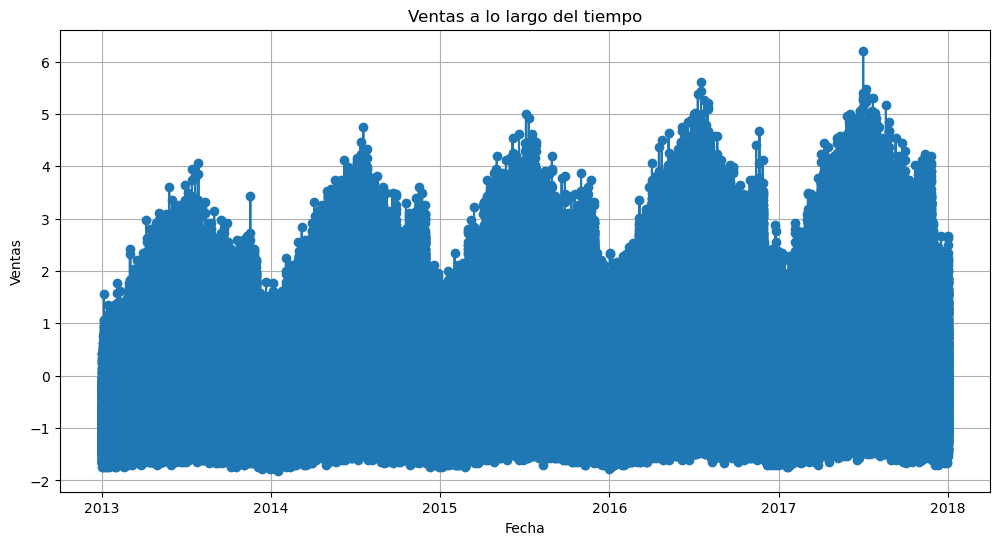

Valores de las ventas a lo largo del tiempo:
             date     sales
0      2013-01-01 -1.362804
211816 2013-01-01 -0.911433
832656 2013-01-01 -0.876712
213642 2013-01-01  0.060752
215468 2013-01-01 -0.598945
...           ...       ...
619013 2017-12-31 -1.085037
620839 2017-12-31 -0.703107
622665 2017-12-31  0.095472
598927 2017-12-31  1.657911
912999 2017-12-31  1.032936

[913000 rows x 2 columns]


In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_df['date'], train_df['sales'], marker='o', linestyle='-')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Ventas a lo largo del tiempo')
plt.grid(True)
plt.show()

# Imprimir los valores de las ventas a lo largo del tiempo
print("Valores de las ventas a lo largo del tiempo:")
print(train_df[['date', 'sales']])



In [5]:
from sklearn.preprocessing import StandardScaler


# Selecciona las columnas relevantes para la normalización en 'train_df'
columnas_numericas = ['sales']

# Crea un objeto StandardScaler
scaler = StandardScaler()

# Ajusta el escalador en los datos de entrenamiento y transforma los datos
train_df[columnas_numericas] = scaler.fit_transform(train_df[columnas_numericas])

# Verifica los datos transformados en 'train_df'
print("Datos de entrenamiento normalizados:")
print(train_df.head())


Datos de entrenamiento normalizados:
         date  store  item     sales
0  2013-01-01      1     1 -1.362804
1  2013-01-02      1     1 -1.432246
2  2013-01-03      1     1 -1.328083
3  2013-01-04      1     1 -1.362804
4  2013-01-05      1     1 -1.466966


In [6]:
# Preprocesamiento de Datos

# División de series temporales

# Supongamos que tienes una columna de fecha llamada "date" en tus datos.
# Ordena los datos por fecha para asegurarte de que los más recientes estén en el conjunto de prueba.
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.sort_values(by='date', inplace=True)

# Define la fecha de corte para separar los datos en entrenamiento, validación y prueba.
fecha_corte_validacion = '2022-07-01'
fecha_corte_prueba = '2022-10-01'

# Conjunto de entrenamiento
train_set = train_df[train_df['date'] < fecha_corte_validacion]

# Conjunto de validación
validation_set = train_df[(train_df['date'] >= fecha_corte_validacion) & (train_df['date'] < fecha_corte_prueba)]

# Conjunto de prueba
test_set = train_df[train_df['date'] >= fecha_corte_prueba]

# Generación de secuencias

# Define la ventana de tiempo histórico que deseas utilizar para predecir los próximos 3 meses.
ventana_historica = 90  # Por ejemplo, utiliza los últimos 90 días para predecir 3 meses.

def crear_secuencias(df, ventana_historica):
    secuencias = []
    objetivos = []
    for i in range(len(df) - ventana_historica):
        secuencia = df['sales'].values[i:i+ventana_historica]
        objetivo = df['sales'].values[i+ventana_historica:i+ventana_historica+90]  # Pronóstico de 3 meses
        secuencias.append(secuencia)
        objetivos.append(objetivo)
    return np.array(secuencias), np.array(objetivos)

# Crea secuencias para los conjuntos de entrenamiento, validación y prueba
x_train, y_train = crear_secuencias(train_set, ventana_historica)
x_validation, y_validation = crear_secuencias(validation_set, ventana_historica)
x_test, y_test = crear_secuencias(test_set, ventana_historica)

# Verifica las dimensiones de los conjuntos de datos
print("Dimensiones de x_train:", x_train.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de x_validation:", x_validation.shape)
print("Dimensiones de y_validation:", y_validation.shape)
print("Dimensiones de x_test:", x_test.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de x_train: (912910, 90)
Dimensiones de y_train: (912910,)
Dimensiones de x_validation: (0,)
Dimensiones de y_validation: (0,)
Dimensiones de x_test: (0,)
Dimensiones de y_test: (0,)


/var/folders/h4/rlgjjv6s50z2sflx2_9bt49h0000gn/T/ipykernel_23436/1422878017.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(secuencias), np.array(objetivos)


In [14]:
import pandas as pd
import numpy as np

# Carga los datos CSV en DataFrames de pandas
train_df = pd.read_csv('demand-forecasting-kernels-only/train.csv')

# Convierte la columna 'date' en tipo datetime
train_df['date'] = pd.to_datetime(train_df['date'])

# Define la fecha de corte para separar los datos en conjuntos de entrenamiento, validación y prueba
fecha_corte_validacion = train_df['date'].max() - pd.DateOffset(months=3)
fecha_corte_prueba = train_df['date'].max()

# Divide los datos en conjuntos de entrenamiento, validación y prueba
train_set = train_df[train_df['date'] < fecha_corte_validacion]
validation_set = train_df[(train_df['date'] >= fecha_corte_validacion) & (train_df['date'] < fecha_corte_prueba)]
test_set = train_df[train_df['date'] >= fecha_corte_prueba]

# Define la ventana de tiempo histórico que deseas utilizar para predecir los próximos 3 meses
ventana_historica = 90  # Por ejemplo, utiliza los últimos 90 días para predecir 3 meses

# Función para crear secuencias de datos
def crear_secuencias(df, ventana_historica):
    secuencias = []
    objetivos = []
    for i in range(len(df) - ventana_historica):
        secuencia = df['sales'].values[i:i + ventana_historica]
        objetivo = df['sales'].values[i + ventana_historica:i + ventana_historica + 90]  # Pronóstico de 3 meses
        secuencias.append(secuencia)
        objetivos.append(objetivo)
    return np.array(secuencias), np.array(objetivos)

# Crea secuencias para los conjuntos de entrenamiento, validación y prueba
x_train, y_train = crear_secuencias(train_set, ventana_historica)
x_validation, y_validation = crear_secuencias(validation_set, ventana_historica)
x_test, y_test = crear_secuencias(test_set, ventana_historica)

# Verifica las dimensiones de los conjuntos de datos
print("Dimensiones de x_train:", x_train.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de x_validation:", x_validation.shape)
print("Dimensiones de y_validation:", y_validation.shape)
print("Dimensiones de x_test:", x_test.shape)
print("Dimensiones de y_test:", y_test.shape)


/var/folders/h4/rlgjjv6s50z2sflx2_9bt49h0000gn/T/ipykernel_23436/3295337749.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(secuencias), np.array(objetivos)


Dimensiones de x_train: (866410, 90)
Dimensiones de y_train: (866410,)
Dimensiones de x_validation: (45910, 90)
Dimensiones de y_validation: (45910,)
Dimensiones de x_test: (410, 90)
Dimensiones de y_test: (410,)


In [16]:
!pip install tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 18.5 MB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 10.2 MB/s eta 0:00:00
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [18]:
test_df['date'] = pd.to_datetime(test_df['date'])


In [19]:
# Convierte 'test_df' a series temporales
test_series = test_df.set_index('date')

# Asegúrate de que las fechas estén ordenadas en orden ascendente
test_series = test_series.sort_index()


In [22]:
import numpy as np

def crear_secuencias(df, ventana_historica):
    secuencias = []
    objetivos = []
    for i in range(len(df) - ventana_historica):
        secuencia = df['sales'].values[i:i + ventana_historica]
        objetivo = df['sales'].values[i + ventana_historica:i + ventana_historica + 90]  # Pronóstico de 3 meses
        secuencias.append(secuencia)
        objetivos.append(objetivo)
    return np.array(secuencias, dtype=object), np.array(objetivos, dtype=object)




In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam  # Importar el optimizador legacy Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define la arquitectura del modelo
modelo = Sequential()

# Agrega una capa LSTM con un número adecuado de unidades (neuronas)
modelo.add(LSTM(units=64, input_shape=(ventana_historica, 1), return_sequences=True))
modelo.add(Dropout(0.2))

# Agrega más capas LSTM o GRU si es necesario (experimenta según el rendimiento)
# modelo.add(LSTM(units=64, return_sequences=True))
# modelo.add(Dropout(0.2))

# Agrega una capa densa para predicciones finales
modelo.add(Dense(units=90))

# Compila el modelo con el optimizador legacy Adam
modelo.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Define Early Stopping para prevenir el sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Convierte las secuencias a NumPy arrays
x_train = np.array(x_train)
x_validation = np.array(x_validation)

# Convierte los objetivos a tensores 2D (shape: [n_muestras, 90])
y_train = np.vstack(y_train)
y_validation = np.vstack(y_validation)

# Entrena el modelo en los datos de entrenamiento y valida en los datos de validación
historia = modelo.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_validation, y_validation), callbacks=[early_stopping])

# Evalúa el modelo en el conjunto de prueba
resultado = modelo.evaluate(x_test, y_test)
print("Pérdida en el conjunto de prueba:", resultado)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 90 and the array at index 912821 has size 89

## Task 2 - Teoria 

1. ¿Cuál es el problema del gradiente de fuga en las redes LSTM y cómo afecta la efectividad de LSTM para el pronóstico de series temporales?

El problema del gradiente de fuga en las redes LSTM se refiere a la tendencia de los gradientes durante la retropropagación a volverse muy pequeños o muy grandes a medida que se propagan hacia atrás en el tiempo a través de muchas unidades de tiempo en una secuencia larga. Esto puede dificultar el entrenamiento efectivo de modelos LSTM para series temporales, ya que los gradientes pequeños pueden llevar a un entrenamiento lento o a un estancamiento, mientras que los gradientes grandes pueden provocar explosiones del gradiente. Esto afecta la efectividad de LSTM para pronósticos de series temporales, ya que puede dificultar la captura de relaciones a largo plazo en los datos.

2. ¿Cómo se aborda la estacionalidad en los datos de series temporales cuando se utilizan LSTM para realizar pronósticos y qué papel juega la diferenciación en el proceso?

La estacionalidad en los datos de series temporales se aborda en LSTM mediante la diferenciación. La diferenciación implica calcular la diferencia entre valores sucesivos en la serie temporal para eliminar la tendencia y la estacionalidad. Esto convierte la serie en una serie estacionaria que es más fácil de modelar. La diferenciación ayuda a que LSTM capture mejor los patrones temporales en los datos y mejore la precisión de los pronósticos.

3. ¿Cuál es el concepto de "tamaño de ventana" en el pronóstico de series temporales con LSTM y cómo afecta la elección del tamaño de ventana a la capacidad del modelo para capturar patrones a corto y largo plazo?

El "tamaño de ventana" en el pronóstico de series temporales con LSTM se refiere a la cantidad de pasos de tiempo anteriores que se utilizan como entrada para predecir el siguiente paso de tiempo. Un tamaño de ventana más grande permite al modelo capturar patrones a largo plazo en los datos, pero también puede hacer que el modelo sea menos sensible a patrones a corto plazo. Por otro lado, un tamaño de ventana más pequeño se centra en patrones a corto plazo, pero puede perder patrones a largo plazo. La elección del tamaño de ventana depende de la naturaleza de los datos y del equilibrio deseado entre la captura de patrones a corto y largo plazo.